# Compare Task Overhead
Compare the difference sources of task overhead for our runs.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
runs = {
    'Baseline': Path('./prod-runs/baseline_retrain-16/'),
    'Parsl+Redis': Path('./prod-runs/parsl_retrain-16/'),
    'FuncX+Globus': Path('./prod-runs/funcx_retrain-16/'),
}

## Load in Overhead Dataframes
We stored the results of each dataframe

In [3]:
results = {}
for k, path in runs.items():
    # Get the duplicates
    with open(path / 'duplicates.json') as fp:
        dupes = json.load(fp)
    
    # Compute the mean RMSD for each run
    results[k] = pd.concat([
        pd.read_csv(Path(p) / 'processed-results' / 'overheads.csv') for p in dupes
    ])

## Get the Distribution of Times
Make sure there are not significant outliers

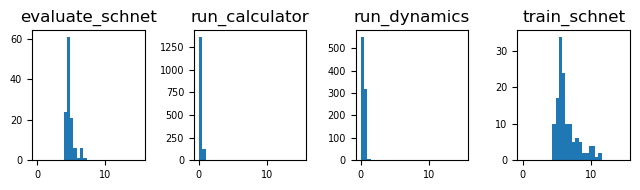

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(6.5, 2.))

for (gid, group), ax in zip(results['FuncX+Globus'].groupby('method'), axs):
    ax.hist(group['overhead_total'], bins=np.linspace(0, 15, 32))
    ax.set_title(gid)
    
fig.tight_layout()

## Make a Box Plot
Plot the overhead for each type on task for each example

Baseline [0.6334197092801332, 3.4833290092065, 7.653050891851308, 5.575091692298884]
Parsl+Redis [0.37724837682367246, 1.4901266084746698, 6.877918490776949, 5.974471134128468]
Parsl+Redis [0.2990791065489365, 1.429661249029449, 0.278491647997542, 0.145496528004093]
FuncX+Globus [6.026285369758966, 4.832714308275001, 0.4599457139432843, 0.3556764939517105]
FuncX+Globus [5.121982635424059, 3.602376076576893, 0.283200565010412, 0.14976687697250798]


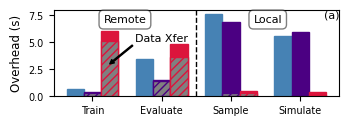

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 1.4))

width = 0.25
colors = {
    'Baseline': 'steelblue',
    'FuncX+Globus': 'crimson',
    'Parsl+Redis': 'indigo'
}

methods = ['train_schnet', 'evaluate_schnet', 'run_dynamics', 'run_calculator']
for i, (name, overheads) in enumerate(results.items()):
    # Make a bar plot where we show the 
    data = [overheads.query(f'method=="{method}"')['overhead_total'].median()
            for method in methods]
    pos = np.arange(4) - len(results) * width / 2 + i * width
    ax.bar(pos, data, color=colors[name], edgecolor=colors[name], width=width, align='edge', label=name)
    print(name, data)
    
    if "+" in name:
        overheads['time_resolving'] = overheads['time_input_resolution'] + overheads['time_output_resolution'] + overheads['overhead_serialization']
        data = [overheads.query(f'method=="{method}"')['time_resolving'].median()
                for method in methods]
        ax.bar(pos, data, color='gray', edgecolor=colors[name], width=width, align='edge', hatch='////')
        print(name, data)

# Make a verical bar denoting which are remote and which are local
#ax.set_yscale('log')
ax.set_ylabel('Overhead (s)')
ax.set_ylim(ax.get_ylim())
ax.plot([1.5]*2, ax.get_ylim(), 'k--', lw=1)

# Annotate what the candy-cane parts mean
ax.annotate('Data Xfer', xy=(0.25, 3), xytext=(1, 5.1), ha='center', fontsize=8,
            arrowprops={"width": 0.75, "color": "k", "headwidth": 3, "headlength": 3})

bbox_kwargs = {'facecolor': 'w', 'alpha': 0.5, "boxstyle": "round, pad=0.4"}
ax.text(0.25, 0.85, 'Remote', ha='center', transform=ax.transAxes, fontsize=8, bbox=bbox_kwargs)
ax.text(0.75, 0.85, 'Local', ha='center', transform=ax.transAxes, fontsize=8, bbox=bbox_kwargs)
ax.text(1, 1, '(a)', ha='right', va='top', transform=ax.transAxes, fontsize=8)


#fig.legend(ncol=3, fontsize=8, loc='upper center')
    
ax.set_xticks([])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Train', 'Evaluate', 'Sample', 'Simulate'])

fig.tight_layout()
fig.savefig('figures/overhead-comparison.png', dpi=320)
fig.savefig('figures/overhead-comparison.pdf')